In [1]:
import ast
import cv2
import glob
import matplotlib.pyplot as plt  # Visualizzazione grafici e immagini
import numpy as np               # Operazioni numeriche su array multidimensionali
import os                       # Interazione con il sistema operativo (file, cartelle)
import pandas as pd             # Manipolazione e analisi di dati tabellari (DataFrame)
import random                   # Funzioni per generazione di numeri casuali
import sys                      # Funzioni per interagire con l'ambiente di esecuzione Python
import torch                    # Libreria principale di deep learning PyTorch (tensori, GPU)
import torch.nn as nn           # Costruzione modelli di reti neurali con layer predefiniti
import torch.nn.functional as F # Funzioni utili come attivazioni, loss, pooling

from collections import defaultdict, Counter
from fvcore.nn import FlopCountAnalysis  # Analisi di FLOPS e complessita' computazionale della rete
from IPython.display import display       # Visualizzazione ricca di output (notebook Jupyter)
from PIL import Image, ImageDraw, ImageFont   # Manipolazione e caricamento immagini
from torch.utils.data import Dataset, DataLoader  # Gestione dataset personalizzati e batching
from torchvision import transforms       # Trasformazioni e preprocessamento immagini
from torchvision.transforms import functional as F
from torchvision.transforms import functional as TF
from torchvision.transforms import Normalize
from torchvision.transforms.functional import resize

import os
import random
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

from itertools import accumulate as _accumulate


In [2]:
# Detect CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print(torch.version.cuda)  # Es: '12.1'
print(torch.cuda.get_device_name(0))

Device: cuda
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# Percorso locale al dataset
dataset_path = 'CCPD2019' 

if os.path.exists(dataset_path):
    print("Dataset trovato in locale!")
else:
    print(f"Dataset non trovato al percorso: {dataset_path}")


Dataset trovato in locale!


In [4]:
# Funzione per decodificare la targa
def decode_plate(plate_str):
    """
    Decodifica la stringa codificata di una targa in una rappresentazione leggibile.

    Parametri:
    - plate_str (str): stringa contenente indici separati da underscore che rappresentano 
      provincia, lettere e numeri della targa.

    Restituisce:
    - str: targa decodificata come combinazione di caratteri provincia, lettere e numeri.
    """
    provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京",
                 "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏",
                 "陕", "甘", "青", "宁", "新", "警", "学", "O"]
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P',
                 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
    ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P',
           'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', 
           '4', '5', '6', '7', '8', '9', 'O']
    
    indices = list(map(int, plate_str.split('_')))
    prov = provinces[indices[0]] if indices[0] < len(provinces) else 'O'
    alpha = alphabets[indices[1]] if indices[1] < len(alphabets) else 'O'
    ads_str = ''.join(ads[i] if i < len(ads) else 'O' for i in indices[2:])
    return prov + alpha + ads_str

stringa_prova = decode_plate("0_1_2_3_5_4_6")
print(f'Prova funzione decode_plate:\n')
print(stringa_prova)

# Funzione per analizzare il nome del file
def parse_filename(filename):
    """
    Analizza un nome file immagine e ne estrae informazioni strutturate.

    Parametri:
    - filename (str): nome del file immagine (es. 'area-tilt-bbox-vertices-plate-brightness-blurriness.jpg').

    Restituisce:
    - dict: dizionario con i seguenti campi:
        - 'area' (str): area del veicolo o zona.
        - 'tilt' (str): inclinazione.
        - 'bbox' (list[int]): bounding box come [x_min, y_min, x_max, y_max].
        - 'vertices' (list[list[int]]): lista di 4 punti vertici [[x1,y1], [x2,y2], ...].
        - 'annotation' (str): targa decodificata.
        - 'brightness' (int or None): luminosita'.
        - 'blurriness' (int or None): sfocatura.

    Lancia ValueError se il nome file non e' conforme.
    """
    name = os.path.splitext(filename)[0]
    parts = name.split('-', maxsplit=6)  # attesi 7 campi
    
    if len(parts) != 7:
        raise ValueError(f"Filename non conforme (attesi 7 campi): {filename}")
    
    area = parts[0]
    tilt = parts[1]

    # Parsing bounding box [x_min, y_min, x_max, y_max]
    bbox_field = parts[2]
    try:
        leftup_str, rightdown_str = bbox_field.split('_')
        x_min, y_min = map(int, leftup_str.split('&'))
        x_max, y_max = map(int, rightdown_str.split('&'))
        bbox = [x_min, y_min, x_max, y_max]
    except Exception:
        bbox = None

    # Parsing vertici: trasformo da "x1&y1_x2&y2_x3&y3_x4&y4" a [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
    vertices_str = parts[3]
    try:
        vertices_points = vertices_str.split('_')
        vertices = [list(map(int, point.split('&'))) for point in vertices_points]
    except Exception:
        vertices = None

    plate_field = parts[4]
    annotation = decode_plate(plate_field)

    brightness = int(parts[5]) if parts[5].isdigit() else None
    blurriness = int(parts[6]) if parts[6].isdigit() else None

    return {
        'area': area,
        'tilt': tilt,
        'bbox': bbox,
        'vertices': vertices,
        'annotation': annotation,
        'encoded_label': plate_field,
        'brightness': brightness,
        'blurriness': blurriness
    }

filename_test = parse_filename("01-86_91-298&341_449&414-458&394_308&410_304&357_454&341-0_0_14_28_24_26_29-124-24.jpg")
print(f'Prova funzione parse_filename:\n')
print(filename_test)

# Funzione crop della targa
def crop_plate_image(row, dataset_path, size=(100, 32)):
    """
    Ritaglia la bbox esatta, ridimensiona a dimensione OCR-friendly, restituisce crop PIL + label.
    """
    image_path = os.path.join(dataset_path, row['image_path'])
    if not os.path.isfile(image_path):
        return None

    image = Image.open(image_path).convert("RGB")
    bbox = row['bbox']
    if isinstance(bbox, str):
        bbox = ast.literal_eval(bbox)

    x_min, y_min, x_max, y_max = bbox
    crop = image.crop((x_min, y_min, x_max, y_max))
    crop = crop.resize(size, Image.BILINEAR)

    label = row['annotation']
    return crop, label



Prova funzione decode_plate:

皖BCDFEG
Prova funzione parse_filename:

{'area': '01', 'tilt': '86_91', 'bbox': [298, 341, 449, 414], 'vertices': [[458, 394], [308, 410], [304, 357], [454, 341]], 'annotation': '皖AQ4025', 'encoded_label': '0_0_14_28_24_26_29', 'brightness': 124, 'blurriness': 24}


In [5]:
# VALIDATION SET
# Dataset: carica CSV
dataset_path = 'CCPD2019'
df = pd.read_csv('val.csv')  # oppure val.csv o test.csv

# Aggiungi bbox + annotation
df['annotation'] = df['image_path'].apply(lambda fn: parse_filename(fn)['annotation'])
df['bbox'] = df['image_path'].apply(lambda fn: parse_filename(fn)['bbox'])

print(df.head())

# Loop: crea immagini + labels.txt, VALIDATION set
output_dir = './data_val/onlyLP_val'
os.makedirs(output_dir, exist_ok=True)

labels_path = labels_path = './data_val/labels_val.txt'

label_lines = [] # inizializzo l'array di labels

for idx, row in df.iterrows():
    result = crop_plate_image(row, dataset_path)
    if result is None:
        continue

    crop, label = result

    filename = f"{idx:06d}.jpg"
    output_path = os.path.join(output_dir, filename)
    crop.save(output_path)

    label_lines.append(f"{filename}\t{label}\n")



                                          image_path          area    tilt  \
0  ccpd_base/0219683908046-89_84-126&620_414&687-...  219683908046   89_84   
1  ccpd_base/0384159482759-87_93-367&427_654&550-...  384159482759   87_93   
2  ccpd_base/03-92_88-249&560_561&670-561&668_265...             3   92_88   
3  ccpd_base/0283908045977-91_84-150&476_476&577-...  283908045977   91_84   
4  ccpd_base/0326329022988-100_79-238&380_495&513...  326329022988  100_79   

                   bbox                                          vertices  \
0  [126, 620, 414, 687]  [[414, 688], [144, 694], [122, 619], [392, 613]]   
1  [367, 427, 654, 550]  [[656, 527], [369, 554], [379, 441], [666, 414]]   
2  [249, 560, 561, 670]  [[561, 668], [265, 654], [266, 562], [562, 576]]   
3  [150, 476, 476, 577]  [[482, 585], [148, 572], [139, 473], [473, 486]]   
4  [238, 380, 495, 513]  [[501, 522], [242, 467], [236, 368], [495, 423]]   

  annotation               encoded_label  brightness  blurriness  
0

In [6]:
with open(labels_path, 'w', encoding='utf-8') as f:
    f.writelines(label_lines)

print(f"[INFO] Generati {len(label_lines)} crop in '{output_dir}' e labels in '{labels_path}'")

[INFO] Generati 99996 crop in './data_val/onlyLP_val' e labels in './data_val/labels_val.txt'


In [7]:
# TRAINING SET
# Dataset: carica CSV
dataset_path = 'CCPD2019'
df = pd.read_csv('train.csv')  # oppure val.csv o test.csv

# Aggiungi bbox + annotation
df['annotation'] = df['image_path'].apply(lambda fn: parse_filename(fn)['annotation'])
df['bbox'] = df['image_path'].apply(lambda fn: parse_filename(fn)['bbox'])

print(df.head())

# Loop: crea immagini + labels.txt, VALIDATION set
output_dir = './data_train/onlyLP_train'
os.makedirs(output_dir, exist_ok=True)

labels_path = labels_path = './data_train/labels_train.txt'

label_lines = [] # inizializzo l'array di labels

for idx, row in df.iterrows():
    result = crop_plate_image(row, dataset_path)
    if result is None:
        continue

    crop, label = result

    filename = f"{idx:06d}.jpg"
    output_path = os.path.join(output_dir, filename)
    crop.save(output_path)

    label_lines.append(f"{filename}\t{label}\n")



                                          image_path          area   tilt  \
0  ccpd_base/0092816091954-94_82-181&490_358&548-...   92816091954  94_82   
1  ccpd_base/0104418103448-91_84-329&442_511&520-...  104418103448  91_84   
2  ccpd_base/023275862069-90_86-173&473_468&557-4...   23275862069  90_86   
3  ccpd_base/0344827586207-92_75-255&369_564&505-...  344827586207  92_75   
4  ccpd_base/0144516283524-97_72-90&538_280&616-2...  144516283524  97_72   

                   bbox                                          vertices  \
0  [181, 490, 358, 548]  [[363, 554], [189, 540], [190, 484], [364, 498]]   
1  [329, 442, 511, 520]  [[515, 519], [340, 508], [326, 447], [501, 458]]   
2  [173, 473, 468, 557]  [[485, 563], [189, 555], [187, 469], [483, 477]]   
3  [255, 369, 564, 505]  [[560, 520], [256, 454], [239, 349], [543, 415]]   
4   [90, 538, 280, 616]    [[278, 629], [95, 595], [85, 525], [268, 559]]   

  annotation               encoded_label  brightness  blurriness  
0    皖A

In [8]:
with open(labels_path, 'w', encoding='utf-8') as f:
    f.writelines(label_lines)

print(f"[INFO] Generati {len(label_lines)} crop in '{output_dir}' e labels in '{labels_path}'")

[INFO] Generati 100000 crop in './data_train/onlyLP_train' e labels in './data_train/labels_train.txt'


In [9]:
# creazione di file test.csv completo
dataset_root = 'CCPD2019'
categorie_target = ['ccpd_blur', 'ccpd_db', 'ccpd_fn', 'ccpd_rotate', 'ccpd_tilt', 'ccpd_weather','ccpd_challenge']

records = []

for cat in categorie_target:
    category_dir = os.path.join(dataset_root, cat)
    if not os.path.exists(category_dir):
        print(f" Directory non trovata: {category_dir}")
        continue

    for img_file in os.listdir(category_dir):
        if not (img_file.endswith('.jpg') or img_file.endswith('.png')):
            continue

        image_path = f"{cat}/{img_file}"
        filename = os.path.basename(img_file)  # solo nome file
        parsed = parse_filename(filename)


        record = {
            'image_path': image_path,
            'area': parsed.get('area', None),
            'tilt': parsed.get('tilt', None),
            'bbox': parsed.get('bbox', None),
            'vertices': parsed.get('vertices', None),
            'annotation': parsed.get('annotation', None),
            'encoded_label': parsed.get('encoded_label', None),
            'brightness': parsed.get('brightness', None),
            'blurriness': parsed.get('blurriness', None)
        }
        records.append(record)

df = pd.DataFrame(records)

# Salva CSV
df.to_csv('test.csv', index=False)
print(f" File test.csv salvato con {len(df)} immagini.")
print(df.columns)
print(df.head())



 File test.csv salvato con 151981 immagini.
Index(['image_path', 'area', 'tilt', 'bbox', 'vertices', 'annotation',
       'encoded_label', 'brightness', 'blurriness'],
      dtype='object')
                                          image_path  area tilt  \
0  ccpd_blur/0019-1_1-340&500_404&526-404&524_340...  0019  1_1   
1  ccpd_blur/0022-0_1-360&474_433&500-432&500_360...  0022  0_1   
2  ccpd_blur/0022-0_2-289&482_362&508-361&508_289...  0022  0_2   
3  ccpd_blur/0022-0_4-337&385_411&410-411&410_339...  0022  0_4   
4  ccpd_blur/0023-0_0-290&386_367&412-367&412_290...  0023  0_0   

                   bbox                                          vertices  \
0  [340, 500, 404, 526]  [[404, 524], [340, 526], [340, 502], [404, 500]]   
1  [360, 474, 433, 500]  [[432, 500], [360, 499], [361, 474], [433, 475]]   
2  [289, 482, 362, 508]  [[361, 508], [289, 508], [290, 482], [362, 482]]   
3  [337, 385, 411, 410]  [[411, 410], [339, 410], [337, 385], [409, 385]]   
4  [290, 386, 367, 412

In [10]:
# TEST SET
# Dataset: carica CSV
dataset_path = 'CCPD2019'
df = pd.read_csv('test.csv')  # oppure val.csv o test.csv

# Aggiungi bbox + annotation
df['annotation'] = df['image_path'].apply(lambda fn: parse_filename(fn)['annotation'])
df['bbox'] = df['image_path'].apply(lambda fn: parse_filename(fn)['bbox'])

print(df.head())

# Loop: crea immagini + labels.txt, VALIDATION set
output_dir = './data_test/onlyLP_test'
os.makedirs(output_dir, exist_ok=True)

# path del file labels:
labels_path = './data_test/labels_test.txt'

label_lines = [] # inizializzo l'array di labels

for idx, row in df.iterrows():
    result = crop_plate_image(row, dataset_path)
    if result is None:
        continue

    crop, label = result

    filename = f"{idx:06d}.jpg"
    output_path = os.path.join(output_dir, filename)
    crop.save(output_path)

    label_lines.append(f"{filename}\t{label}\n")



                                          image_path  area tilt  \
0  ccpd_blur/0019-1_1-340&500_404&526-404&524_340...    19  1_1   
1  ccpd_blur/0022-0_1-360&474_433&500-432&500_360...    22  0_1   
2  ccpd_blur/0022-0_2-289&482_362&508-361&508_289...    22  0_2   
3  ccpd_blur/0022-0_4-337&385_411&410-411&410_339...    22  0_4   
4  ccpd_blur/0023-0_0-290&386_367&412-367&412_290...    23  0_0   

                   bbox                                          vertices  \
0  [340, 500, 404, 526]  [[404, 524], [340, 526], [340, 502], [404, 500]]   
1  [360, 474, 433, 500]  [[432, 500], [360, 499], [361, 474], [433, 475]]   
2  [289, 482, 362, 508]  [[361, 508], [289, 508], [290, 482], [362, 482]]   
3  [337, 385, 411, 410]  [[411, 410], [339, 410], [337, 385], [409, 385]]   
4  [290, 386, 367, 412]  [[367, 412], [290, 411], [290, 386], [367, 387]]   

  annotation       encoded_label  brightness  blurriness  
0    皖AM214T  0_0_11_26_25_28_17          66           3  
1    皖AW023L  0_

In [11]:
with open(labels_path, 'w', encoding='utf-8') as f:
    f.writelines(label_lines)

print(f"[INFO] Generati {len(label_lines)} crop in '{output_dir}' e labels in '{labels_path}'")

[INFO] Generati 151981 crop in './data_test/onlyLP_test' e labels in './data_test/labels_test.txt'


In [12]:
# preparazione della cartella TEST splittata per poi fare inference separate
dataset_path = 'CCPD2019'
df = pd.read_csv('test.csv', header=None, usecols=[0], names=['image_path'])
print(df.head())

categorie_target = ['ccpd_blur', 'ccpd_db', 'ccpd_fn', 'ccpd_rotate','ccpd_challenge' ,'ccpd_tilt', 'ccpd_weather']
# 'ccpd_np'
output_root = './data_test_split'
os.makedirs(output_root, exist_ok=True)

def resize_32x100(pil_img):
    return pil_img.resize((100, 32), Image.BILINEAR)

totali = {cat: 0 for cat in categorie_target}

label_files = {}
for cat in categorie_target:
    cat_dir = os.path.join(output_root, cat)
    data_dir = os.path.join(cat_dir, 'data')
    os.makedirs(data_dir, exist_ok=True)
    label_files[cat] = open(os.path.join(cat_dir, 'labels.txt'), 'w', encoding='utf-8')

for idx, row in df.iterrows():
    image_rel_path = row['image_path']
    categoria = image_rel_path.split('/')[0]

    if categoria not in categorie_target:
        continue

    image_full_path = os.path.join(dataset_path, image_rel_path)
    if not os.path.exists(image_full_path):
        print(f"⚠️ Immagine non trovata: {image_full_path}")
        continue

    image = Image.open(image_full_path).convert('RGB')

    # Parsing filename per bbox e label:
    parsed = parse_filename(image_rel_path)
    bbox = parsed['bbox']
    label = parsed['annotation']

    # Cropping immagine
    x1, y1, x2, y2 = bbox
    crop = image.crop((x1, y1, x2, y2))
    crop = resize_32x100(crop)

    filename = f"{totali[categoria]:06d}.jpg"
    out_img_path = os.path.join(output_root, categoria, 'data', filename)
    crop.save(out_img_path)

    label_files[categoria].write(f"{filename}\t{label}\n")
    totali[categoria] += 1

for f in label_files.values():
    f.close()

print("Completato:")
for cat in categorie_target:
    print(f"{cat}: {totali[cat]} immagini salvate.")


                                          image_path
0                                         image_path
1  ccpd_blur/0019-1_1-340&500_404&526-404&524_340...
2  ccpd_blur/0022-0_1-360&474_433&500-432&500_360...
3  ccpd_blur/0022-0_2-289&482_362&508-361&508_289...
4  ccpd_blur/0022-0_4-337&385_411&410-411&410_339...
Completato:
ccpd_blur: 20611 immagini salvate.
ccpd_db: 10132 immagini salvate.
ccpd_fn: 20967 immagini salvate.
ccpd_rotate: 10053 immagini salvate.
ccpd_challenge: 50003 immagini salvate.
ccpd_tilt: 30216 immagini salvate.
ccpd_weather: 9999 immagini salvate.


Augmentation attiva: verranno applicate trasformazioni ai dati di input.
 Batch generato: torch.Size([6, 3, 32, 100]), labels: ['000000', '000000', '000001', '000001', '000002', '000002']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


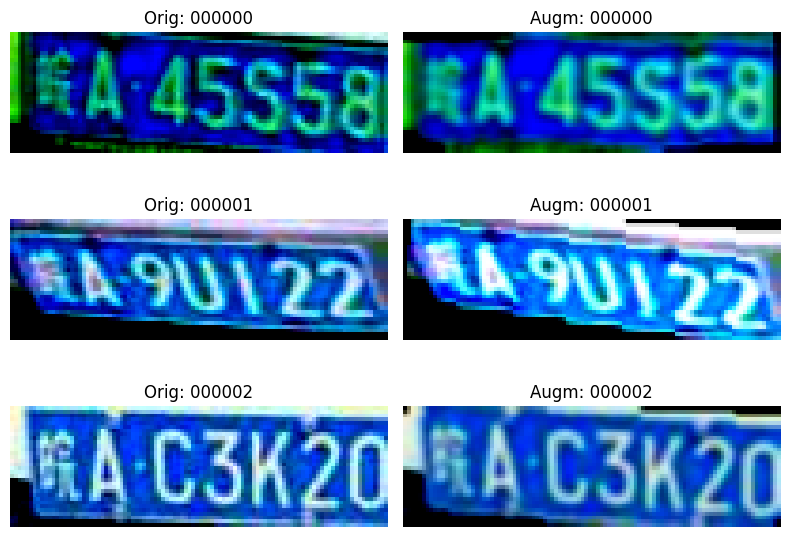

In [13]:
from deep_text_recognition_benchmark.dataset import AlignCollate
# Test della funzione di augmentazione:

# Percorso dataset
dataset_path = "./data_train/onlyLP_train"

# ---- Carica prime 3 immagini ----
images = [f for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]
images.sort()
images = images[:3]

if not images:
    print(" Nessuna immagine trovata nel dataset!")
    exit()

# ---- Carica immagini con PIL ----
pil_images = [Image.open(os.path.join(dataset_path, img)).convert("RGB") for img in images]
labels = [img.split('.')[0] for img in images]  # etichetta semplice col nome file

# ---- Setup AlignCollate con augmentation attiva ----
collate_fn = AlignCollate(imgH=32, imgW=100, keep_ratio_with_pad=True, is_training=True)

# ---- Simula batch come lista di tuple (immagine, label) ----
batch = [(img, label) for img, label in zip(pil_images, labels)]

# ---- Applica AlignCollate ----
image_tensors, augmented_labels = collate_fn(batch)

print(f" Batch generato: {image_tensors.shape}, labels: {augmented_labels}")

# ---- Visualizza originale e augmentata ----
plt.figure(figsize=(8, 6))

for i in range(3):
    # Indici nel tensor: originale = 2i, augmentata = 2i+1
    img_orig = image_tensors[2 * i].squeeze().permute(1, 2, 0).numpy()
    img_aug = image_tensors[2 * i + 1].squeeze().permute(1, 2, 0).numpy()

    plt.subplot(3, 2, i*2 + 1)
    plt.imshow(img_orig, cmap='gray')
    plt.title(f"Orig: {labels[i]}")
    plt.axis('off')

    plt.subplot(3, 2, i*2 + 2)
    plt.imshow(img_aug, cmap='gray')
    plt.title(f"Augm: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# mettere il comando per generare il dataset dalla riga dei comandi:

python3 deep_text_recognition_benchmark/create_lmdb_dataset.py^
--inputPath onlyLP_test_split/ccpd_blur/data --gtFile onlyLP_test_split/ccpd_blur/labels.txt ^
--outputPath data_test_split/ccpd_blur

# in seguito creare le cartelle MJ e ST! in cui copiare

In [ ]:
# comando di allenamento:
python3 deep_text_recognition_benchmark/train.py --train_data train_lmdb --valid_data val_lmdb ^
--select_data MJ-ST --batch_ratio 0.5-0.5 --Transformation TPS --FeatureExtraction ResNet ^ 
--SequenceModeling BiLSTM --Prediction Attn ^
--saved_model saved_models/TPS-ResNet-BiLSTM-Attn.pth --num_iter 10420 ^ 
--valInterval 2084 --workers 0 --data_filtering_off --batch_size 48


# comando di test/inference:
python3 deep_text_recognition_benchmark/test.py --eval_data val_lmdb/MJ^
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM ^
--Prediction Attn --saved_model saved_models/TPS-ResNet-BiLSTM-Attn-Seed1111/best_accuracy.pth ^
--workers 0 --data_filtering_off
